## Use Decision Tree for forcast IMOEX price
### Vol 6
#### 21.06.19

In [8]:
# connecting nessesary paceges
from pandas import read_csv as read
from pandas import DataFrame as DF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from IPython.display import SVG
from IPython.display import display
from graphviz import Source
from IPython.display import HTML
style = "<style>svg{width:80% !important;height:80% !important;}</style>"
HTML(style)

## In this part we better look on the using decision tree 

In [19]:
git_dir = 'https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/'
data_10 = ['export_Index_10_10.06.txt',
           'export_Index_10_13.06.txt',
           'export_Index_10_14.06.txt',
           'export_Index_10_17.06.txt',
           'export_Index_10_18.06.txt']

In [31]:
scores = DF()
name = [str(i)[14:21] for i in data_10]
clf = DecisionTreeClassifier(criterion='entropy')
for data in data_10:
    link = str(git_dir + data)
    print(link)
    train = read(link, error_bad_lines=False)
    train = train.drop('Time', axis=1)
    train.index = range(len(train))
    train['MOEX_1'] = train.MOEX.shift(-1) # let's try to predict one step forward
    train['MOEX_1'] = DF(train['MOEX_1']).apply(lambda x: np.log(x) - np.log(x).shift(1))
    train.dropna(inplace=True)
    train['MOEX_1'] = train['MOEX_1'].apply(lambda x: 1 if x > 0 else 0) # Change train tipe to boolean type
    train = train.drop(['MOEX'], axis=1)
    X_train = train.drop('MOEX_1', axis=1)
    y_train = train.MOEX_1
    clf.fit(X_train, y_train)
    results = []
    for test in data_10:
        if test == data:
            results.append(1)
            continue
        link = str(git_dir + test)
        tests = read(link, error_bad_lines=False)
        tests = tests.drop('Time', axis=1)
        tests.index = range(len(tests))
        tests['MOEX_1'] = tests.MOEX.shift(-1) # let's try to predict one step forward
        tests['MOEX_1'] = DF(tests['MOEX_1']).apply(lambda x: np.log(x) - np.log(x).shift(1))
        tests.dropna(inplace=True)
        tests['MOEX_1'] = tests['MOEX_1'].apply(lambda x: 1 if x > 0 else 0) # Change test tipe to boolean type
        tests = tests.drop(['MOEX'], axis=1)
        X_test = tests.drop('MOEX_1', axis=1)
        y_test = tests.MOEX_1
        y_pred = clf.predict(X_test)
        results.append(precision_score(y_test, y_pred))
    scores[data] = results 
scores.columns = name
scores.index = name   
scores

https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_10.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_13.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_14.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_17.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_18.06.txt


,0_10.06,0_13.06,0_14.06,0_17.06,0_18.06
0_10.06,1.000000,0.151242,0.149758,0.156989,0.151899
0_13.06,0.162375,1.000000,0.230769,0.281250,0.179612
0_14.06,0.200722,0.179250,1.000000,0.117871,0.184932
0_17.06,0.190169,0.195229,0.209514,1.000000,0.194553
0_18.06,0.187088,0.197195,0.178344,0.203430,1.000000


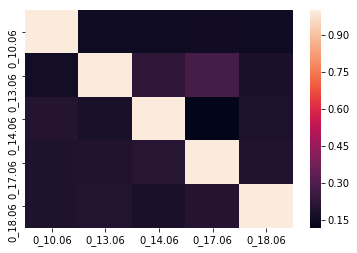

In [33]:
sns.heatmap(scores)

## Report
### As we can see, we can't use data of one day to predict result of other days

## Try to look, how tree predict data

### Helpfull functions

In [34]:
# Result of strategy
def results(data, finish, start, clf, y_columns='MOEX_1'):
    result = []
    fact = []
    while finish <= len(data)-3:
        train = data.iloc[start:finish, :]
        x = train.drop(y_columns, axis=1)
        y = train[y_columns]
        clf.fit(x, y)
        x_test = data.iloc[finish+1:finish+2, :].drop(y_columns,axis=1)
        result.append(int(clf.predict(x_test)))
        fact.append(int(data.iloc[finish+1:finish+2, :].MOEX_1))
        start += 1
        finish += 1
    shares = [] 
    for i in range(len(result)):
        if result[i] == fact[i]:
            shares.append(1)
        else:
            shares.append(0)
    return shares

In [35]:
score_window = DF()

In [41]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)
res = [[] for i in range(len(data_10))]
name = [str(i)[14:21] for i in data_10]
step = 100
num = 0
for d in data_10:
    link = str(git_dir + d)
    print(link)
    data = read(link, error_bad_lines=False)
    data = data.drop('Time', axis=1)
    data.index = range(len(data))
    data['MOEX_1'] = data.MOEX.shift(-1) # let's try to predict one step forward
    data['MOEX_1'] = DF(data['MOEX_1']).apply(lambda x: np.log(x) - np.log(x).shift(1))
    data.dropna(inplace=True)
    data['MOEX_1'] = data['MOEX_1'].apply(lambda x: 1 if x > 0 else 0) # Change data tipe to boolean type
    data = data.drop(['MOEX'], axis=1) 
    start = 0
    finish = start + step
    res[num] = results(data, finish, start, clf, y_columns='MOEX_1')
    num += 1

https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_10.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_13.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_14.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_17.06.txt
https://raw.githubusercontent.com/Aurilino/Python/master/Decision%20Tree%20IMOEX/testing_data/export_Index_10_18.06.txt


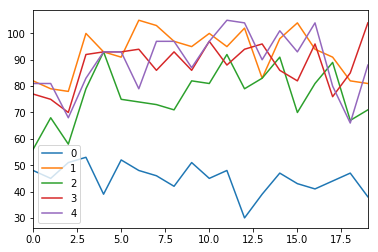

In [68]:
hits_share = [[] for i in range(len(res))]
num = 0
for i in res:
    l = len(i) // 20
    s = 0
    f = l
    out = []
    for j in range(20):
        out.append(sum(i[s:f]))
        s += l
        f += l
    hits_share[num] = out
    num += 1
hits_share = DF(hits_share) 
hits_share.T.plot()

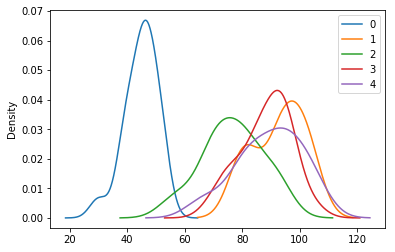

In [69]:
hits_share.T.plot.kde()

## We see that the amount of data that the tree received does not affect the prediction result